In [1]:
# %load utils/imports.py
%matplotlib inline
import numpy as np
import pandas as pd
from utils import *
#from utils.styles import *

# %load utils/plotting.py
import seaborn as sns
from plotly.offline import init_notebook_mode, iplot
import cufflinks as cf

init_notebook_mode()
cf.go_offline()
import re

In [120]:
# import data
df = pd.read_csv('data/flightdelay.csv') # flight delay data
ap = pd.read_csv('data/airport_passenger.csv') # airport passenger
airport = pd.read_csv('data/airports.csv', names = ['name', 'city', 'country', 'iata', 'icao', 'lat', 'lon', 'alt', 'timezone', 'dst', 'tz']) # airport data
holiday =  pd.read_csv('data/us_holiday.csv') # holiday data

In [122]:
# data cleaning and adding feature
cols = ['name', 'city', 'country', 'iata', 'lat', 'lon', 'alt', 'timezone', 'tz']
airport = airport[cols]
airport.head(10)

name          city           country iata  \
1                       Goroka        Goroka  Papua New Guinea  GKA   
2                       Madang        Madang  Papua New Guinea  MAG   
3                  Mount Hagen   Mount Hagen  Papua New Guinea  HGU   
4                       Nadzab        Nadzab  Papua New Guinea  LAE   
5   Port Moresby Jacksons Intl  Port Moresby  Papua New Guinea  POM   
6                   Wewak Intl         Wewak  Papua New Guinea  WWK   
7                   Narsarsuaq  Narssarssuaq         Greenland  UAK   
8                         Nuuk      Godthaab         Greenland  GOH   
9            Sondre Stromfjord   Sondrestrom         Greenland  SFJ   
10              Thule Air Base         Thule         Greenland  THU   

          lat         lon   alt  timezone                    tz  
1   -6.081689  145.391881  5282      10.0  Pacific/Port_Moresby  
2   -5.207083  145.788700    20      10.0  Pacific/Port_Moresby  
3   -5.826789  144.295861  5388      10.0  Pacific/Port_Moresby  
4   -6.569828  146.726242   239      10.0  Pacific/Port_Moresby  
5   -9.443383  147.220050   146      10.0  Pacific/Port_Moresby  
6   -3.583828  143.669186    19      10.0  Pacific/Port_Moresby  
7   61.160517  -45.425978   112      -3.0       America/Godthab  
8   64.190922  -51.678064   283      -3.0       America/Godthab  
9   67.016969  -50.689325   165      -3.0       America/Godthab  
10  76.531203  -68.703161   251      -4.0         America/Thule

In [123]:
catcol = ['unique_carrier', 'origin', 'origin_city_name', 'origin_state_abr', 'dest', 'dest_city_name', 'dest_state_abr']
df[catcol] = df[catcol].apply(lambda c: c.astype('category'))
df.head()

Unnamed: 0  year  month  day_of_month  day_of_week unique_carrier origin  \
0           0  2015      1             6            2             AA    JFK   
1           1  2015      1            24            6             AA    JFK   
2           2  2015      1             3            6             AA    LAX   
3           3  2015      1             4            7             AA    LAX   
4           4  2015      1            28            3             AA    LAX   

  origin_city_name origin_state_abr dest         ...          crs_dep_time  \
0     New York, NY               NY  LAX         ...                   900   
1     New York, NY               NY  LAX         ...                   900   
2  Los Angeles, CA               CA  JFK         ...                   900   
3  Los Angeles, CA               CA  JFK         ...                   900   
4  Los Angeles, CA               CA  JFK         ...                   900   

  crs_arr_time  distance  dep_delay  arr_delay  carrier_delay  weather_delay  \
0         1235    2475.0       -4.0       25.0            0.0            0.0   
1         1235    2475.0      103.0       79.0            0.0           79.0   
2         1735    2475.0       22.0       24.0           22.0            0.0   
3         1735    2475.0      161.0      150.0            0.0            0.0   
4         1729    2475.0       40.0       28.0           28.0            0.0   

   nas_delay  security_delay  late_aircraft_delay  
0       25.0             0.0                  0.0  
1        0.0             0.0                  0.0  
2        2.0             0.0                  0.0  
3       45.0             0.0                105.0  
4        0.0             0.0                  0.0  

[5 rows x 22 columns]

In [124]:
# data cleaning and adding feature
cols = ['name', 'city', 'country', 'iata', 'lat', 'lon', 'alt', 'timezone', 'tz']
airport = airport[cols]

catcol = ['unique_carrier', 'origin', 'origin_city_name', 'origin_state_abr', 'dest', 'dest_city_name', 'dest_state_abr']
df[catcol] = df[catcol].apply(lambda c: c.astype('category'))

holiday = holiday.drop(holiday.index[365:])
holiday['date'] = pd.to_datetime(holiday['date'])
holiday = holiday.fillna(0)
holiday['hol_rating'] = holiday.weekend + holiday.fed_hol + holiday.a_hol + holiday.l_hol

# Remove the airport which is not in the airport list
apl = ap.iata.tolist()
include = df.origin.isin(apl) & df.dest.isin(apl)
df = df[include].reset_index(drop=True).copy()

include = airport.iata.isin(apl)
airport = airport[include]
airport = airport.reset_index(drop=True)

# convert year, month and day_of_week to datetime
df['flight_date'] = pd.to_datetime(df.year.astype(str) + '-' + df.month.astype(str) + '-' + df.day_of_month.astype(str))

# define route
df['route'] = df.origin.astype(str) + '-' + df.dest.astype(str)

# create a rating of airports based on the number of passenger (in 2014), here, we divide the passeger by 1000000
def br(s):
    # s is the string in the columns 'y2014' and 'y2015'
    rating = float(re.sub(r'[^\w]', '', s))/1000000
    return rating
ap['busy_rating'] = ap.y2014.apply(br)

# definte a function to convert crs_dep_time and crs_arr_time to 24 hour
def time_convert(t):
    time = int(t/100)
    if t%100 >= 30:
        time += 1
    else:
        time = time
    if time == 24:
        time = 0
    elif time > 24:
        print 'Error! cannot over 24'
    return time
    
df['cdt'] = df.crs_dep_time.apply(time_convert)
df['cat'] = df.crs_arr_time.apply(time_convert)

# write a function to merge table
def merge_table(df1, df2, df1_col, df2_col, add_columns, col_name):
    # df1 is the original dataframe, df2 is the new column add to df1
    # df1_col and df2_col are the inner join of the two dataframe
    # *add_columns is a list of columns that add to df1
    # *col_name is the list of new columns names
    df2[df1_col] = df2[df2_col]
    join_df = pd.merge(df1, df2, on = df1_col)
    for c in range(0, len(add_columns)):
        df1[col_name[c]] = join_df[add_columns[c]]
    return df1

# Feature engineering
# add variables based on airport busy level
df = merge_table(df, ap, 'origin', 'iata', ['busy_rating'], ['origin_br'])
df = merge_table(df, ap, 'dest', 'iata', ['busy_rating'], ['dest_br'])

# add variables based on airport 
df = merge_table(df, airport, 'origin', 'iata', ['lat', 'lon'], ['origin_lat', 'origin_lon'])
df = merge_table(df, airport, 'dest', 'iata', ['lat', 'lon'], ['dest_lat', 'dest_lon'])
df['trave_lat'] = df.dest_lat - df.origin_lat
df['trave_lon'] = df.dest_lon - df.origin_lon

# add variables based on holidays
df = merge_table(df, holiday, 'flight_date', 'date', ['weekend','fed_hol','a_hol','l_hol','hol_rating'],['weekend','fed_hol','a_hol','l_hol','hol_rating'])

# drop the first column
df = df.drop(df.columns[0], axis=1).copy()

In [125]:
# Check for missing values
is_null = lambda col: sum(pd.isnull(df[col]))
missing_values = [(col,is_null(col)) for col in df if is_null(col)]
missing_values

[]

In [127]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 755142 entries, 0 to 755141
Data columns (total 38 columns):
year                   755142 non-null int64
month                  755142 non-null int64
day_of_month           755142 non-null int64
day_of_week            755142 non-null int64
unique_carrier         755142 non-null category
origin                 755142 non-null category
origin_city_name       755142 non-null category
origin_state_abr       755142 non-null category
dest                   755142 non-null category
dest_city_name         755142 non-null category
dest_state_abr         755142 non-null category
crs_dep_time           755142 non-null int64
crs_arr_time           755142 non-null int64
distance               755142 non-null float64
dep_delay              755142 non-null float64
arr_delay              755142 non-null float64
carrier_delay          755142 non-null float64
weather_delay          755142 non-null float64
nas_delay              755142 non-null float64
s

In [128]:
df_selected = df[df['late_aircraft_delay']== 0]
df_selected.info()
# exclude the late aircrat delay impact - which may due to the origin airport instead of the destination airport

<class 'pandas.core.frame.DataFrame'>
Int64Index: 367633 entries, 0 to 755140
Data columns (total 38 columns):
year                   367633 non-null int64
month                  367633 non-null int64
day_of_month           367633 non-null int64
day_of_week            367633 non-null int64
unique_carrier         367633 non-null category
origin                 367633 non-null category
origin_city_name       367633 non-null category
origin_state_abr       367633 non-null category
dest                   367633 non-null category
dest_city_name         367633 non-null category
dest_state_abr         367633 non-null category
crs_dep_time           367633 non-null int64
crs_arr_time           367633 non-null int64
distance               367633 non-null float64
dep_delay              367633 non-null float64
arr_delay              367633 non-null float64
carrier_delay          367633 non-null float64
weather_delay          367633 non-null float64
nas_delay              367633 non-null float64
s

In [138]:
Carrier = df_selected['unique_carrier'].value_counts()
Carrier_percent = pd.concat([Carrier, Carrier * 100 / float(sum(Carrier))], axis=1)
Carrier_percent

unique_carrier  unique_carrier
AA           67085       18.247818
WN           61191       16.644588
DL           54810       14.908890
UA           51451       13.995207
B6           22354        6.080521
US           21796        5.928739
NK           19863        5.402943
OO           17418        4.737877
EV           13004        3.537223
AS           10992        2.989938
F9           10815        2.941792
MQ            7515        2.044158
VX            6351        1.727538
HA            2988        0.812767

In [139]:
Dest = df_selected['dest'].value_counts()
Dest_percent = pd.concat([Dest, Dest * 100 / float(sum(Dest))], axis=1)
Dest_percent

dest      dest
LAX  21686  5.898818
ORD  20723  5.636872
ATL  16837  4.579839
SFO  16324  4.440298
DFW  14600  3.971352
LGA  14150  3.848947
DEN  14014  3.811954
IAH  11285  3.069637
BOS  10896  2.963825
PHX  10885  2.960833
MCO  10775  2.930912
EWR  10739  2.921120
JFK  10554  2.870798
LAS  10036  2.729896
SEA   8971  2.440205
CLT   8834  2.402940
PHL   8327  2.265031
MIA   8288  2.254422
FLL   7807  2.123585
MSP   7805  2.123041
DCA   7789  2.118689
DTW   7256  1.973707
TPA   5680  1.545019
SAN   5499  1.495785
BWI   5428  1.476472
MDW   4933  1.341827
SLC   4475  1.217247
AUS   4126  1.122315
HNL   3898  1.060297
STL   3454  0.939524
..     ...       ...
MQT      0  0.000000
MRY      0  0.000000
MSN      0  0.000000
MSO      0  0.000000
MVY      0  0.000000
LRD      0  0.000000
MYR      0  0.000000
OAJ      0  0.000000
OKC      0  0.000000
OME      0  0.000000
ORF      0  0.000000
ORH      0  0.000000
MMH      0  0.000000
MLU      0  0.000000
MLI      0  0.000000
MLB      0  0.000000
MKG      0  0.000000
MHT      0  0.000000
MHK      0  0.000000
MGM      0  0.000000
MFR      0  0.000000
MFE      0  0.000000
MEM      0  0.000000
MEI      0  0.000000
MDT      0  0.000000
MBS      0  0.000000
MAF      0  0.000000
LWS      0  0.000000
LSE      0  0.000000
ABE      0  0.000000

[322 rows x 2 columns]

In [140]:
month = df_selected['month'].value_counts()
month_percent = pd.concat([month, month * 100 / float(sum(Dest))], axis=1)
month_percent

month      month
6   37359  10.162037
7   35001   9.520636
8   32945   8.961383
3   32763   8.911877
2   32578   8.861555
12  32224   8.765263
1   31376   8.534598
5   31173   8.479380
4   29400   7.997106
11  25769   7.009436
9   23710   6.449367
10  23335   6.347363

In [141]:
week = df_selected['day_of_week'].value_counts()
week_percent = pd.concat([week, week * 100 / float(sum(Dest))], axis=1)
week_percent

day_of_week  day_of_week
4        58952    16.035557
1        55749    15.164308
5        55633    15.132755
3        52693    14.333044
2        52504    14.281634
7        50489    13.733533
6        41613    11.319169

In [142]:
print df_selected.groupby(['dest','unique_carrier']).count().max(1).sort_values(ascending=False)
# for the top 10 and look for those with more even distributin of unique carrier (lower the impact of airline hubs)

dest  unique_carrier
DFW   AA                10031.0
ATL   DL                 9750.0
MIA   AA                 6085.0
ORD   UA                 5965.0
IAH   UA                 5875.0
SFO   UA                 5602.0
ORD   AA                 5121.0
EWR   UA                 4662.0
DEN   UA                 4453.0
MDW   WN                 4434.0
LAX   AA                 4191.0
      UA                 4009.0
MSP   DL                 3796.0
JFK   B6                 3670.0
LGA   DL                 3546.0
CLT   AA                 3540.0
      US                 3535.0
LAX   WN                 3516.0
SEA   AS                 3461.0
DTW   DL                 3283.0
DEN   WN                 3227.0
JFK   DL                 3098.0
BOS   B6                 3041.0
LAS   WN                 2864.0
LAX   DL                 2851.0
BWI   WN                 2806.0
ATL   WN                 2759.0
PHX   AA                 2738.0
LGA   AA                 2694.0
PHX   WN                 2678.0
                   

In [143]:
table = df_selected[['dest','day_of_week','month']].groupby(['dest','day_of_week']).count().unstack()
table

month                                                
day_of_week       1       2       3       4       5       6       7
dest                                                               
ABE             NaN     NaN     NaN     NaN     NaN     NaN     NaN
ABI             NaN     NaN     NaN     NaN     NaN     NaN     NaN
ABQ           238.0   195.0   246.0   248.0   242.0   171.0   211.0
ABR             NaN     NaN     NaN     NaN     NaN     NaN     NaN
ABY             NaN     NaN     NaN     NaN     NaN     NaN     NaN
ACK             NaN     NaN     NaN     NaN     NaN     NaN     NaN
ACT             NaN     NaN     NaN     NaN     NaN     NaN     NaN
ACV             NaN     NaN     NaN     NaN     NaN     NaN     NaN
ACY             NaN     NaN     NaN     NaN     NaN     NaN     NaN
ADK             NaN     NaN     NaN     NaN     NaN     NaN     NaN
ADQ             NaN     NaN     NaN     NaN     NaN     NaN     NaN
AEX             NaN     NaN     NaN     NaN     NaN     NaN     NaN
AGS             NaN     NaN     NaN     NaN     NaN     NaN     NaN
AKN             NaN     NaN     NaN     NaN     NaN     NaN     NaN
ALB             NaN     NaN     NaN     NaN     NaN     NaN     NaN
ALO             NaN     NaN     NaN     NaN     NaN     NaN     NaN
AMA             NaN     NaN     NaN     NaN     NaN     NaN     NaN
ANC           180.0   178.0   231.0   209.0   213.0   169.0   218.0
APN             NaN     NaN     NaN     NaN     NaN     NaN     NaN
ASE             NaN     NaN     NaN     NaN     NaN     NaN     NaN
ATL          2548.0  2356.0  2526.0  2832.0  2520.0  1929.0  2126.0
ATW             NaN     NaN     NaN     NaN     NaN     NaN     NaN
AUS           613.0   527.0   621.0   656.0   621.0   432.0   656.0
AVL             NaN     NaN     NaN     NaN     NaN     NaN     NaN
AVP             NaN     NaN     NaN     NaN     NaN     NaN     NaN
AZO             NaN     NaN     NaN     NaN     NaN     NaN     NaN
BDL           273.0   285.0   263.0   303.0   236.0   223.0   249.0
BET             NaN     NaN     NaN     NaN     NaN     NaN     NaN
BFL             NaN     NaN     NaN     NaN     NaN     NaN     NaN
BGM             NaN     NaN     NaN     NaN     NaN     NaN     NaN
...             ...     ...     ...     ...     ...     ...     ...
SRQ             NaN     NaN     NaN     NaN     NaN     NaN     NaN
STC             NaN     NaN     NaN     NaN     NaN     NaN     NaN
STL           522.0   469.0   525.0   552.0   535.0   349.0   502.0
STT             NaN     NaN     NaN     NaN     NaN     NaN     NaN
STX             NaN     NaN     NaN     NaN     NaN     NaN     NaN
SUN             NaN     NaN     NaN     NaN     NaN     NaN     NaN
SUX             NaN     NaN     NaN     NaN     NaN     NaN     NaN
SWF             NaN     NaN     NaN     NaN     NaN     NaN     NaN
SYR             NaN     NaN     NaN     NaN     NaN     NaN     NaN
TLH             NaN     NaN     NaN     NaN     NaN     NaN     NaN
TOL             NaN     NaN     NaN     NaN     NaN     NaN     NaN
TPA           822.0   753.0   783.0   891.0   842.0   793.0   796.0
TRI             NaN     NaN     NaN     NaN     NaN     NaN     NaN
TTN             NaN     NaN     NaN     NaN     NaN     NaN     NaN
TUL             NaN     NaN     NaN     NaN     NaN     NaN     NaN
TUS             NaN     NaN     NaN     NaN     NaN     NaN     NaN
TVC             NaN     NaN     NaN     NaN     NaN     NaN     NaN
TWF             NaN     NaN     NaN     NaN     NaN     NaN     NaN
TXK             NaN     NaN     NaN     NaN     NaN     NaN     NaN
TYR             NaN     NaN     NaN     NaN     NaN     NaN     NaN
TYS             NaN     NaN     NaN     NaN     NaN     NaN     NaN
UST             NaN     NaN     NaN     NaN     NaN     NaN     NaN
VEL             NaN     NaN     NaN     NaN     NaN     NaN     NaN
VLD             NaN     NaN     NaN     NaN     NaN     NaN     NaN
VPS             NaN     NaN     NaN     NaN     NaN     NaN     NaN
WR

In [145]:
df_LAX= df[df['dest']== "LAX"]
df_LAX.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41102 entries, 0 to 755135
Data columns (total 38 columns):
year                   41102 non-null int64
month                  41102 non-null int64
day_of_month           41102 non-null int64
day_of_week            41102 non-null int64
unique_carrier         41102 non-null category
origin                 41102 non-null category
origin_city_name       41102 non-null category
origin_state_abr       41102 non-null category
dest                   41102 non-null category
dest_city_name         41102 non-null category
dest_state_abr         41102 non-null category
crs_dep_time           41102 non-null int64
crs_arr_time           41102 non-null int64
distance               41102 non-null float64
dep_delay              41102 non-null float64
arr_delay              41102 non-null float64
carrier_delay          41102 non-null float64
weather_delay          41102 non-null float64
nas_delay              41102 non-null float64
security_delay       

In [146]:
df_LAX.describe()

year         month  day_of_month   day_of_week  crs_dep_time  \
count  41102.0  41102.000000  41102.000000  41102.000000  41102.000000   
mean    2015.0      6.554085     15.581140      3.976425   1518.526130   
std        0.0      3.285182      8.732492      2.035476    457.557721   
min     2015.0      1.000000      1.000000      1.000000      8.000000   
25%     2015.0      4.000000      8.000000      2.000000   1140.250000   
50%     2015.0      7.000000     16.000000      4.000000   1630.000000   
75%     2015.0      9.000000     23.000000      6.000000   1905.000000   
max     2015.0     12.000000     31.000000      7.000000   2359.000000   

       crs_arr_time      distance     dep_delay     arr_delay  carrier_delay  \
count  41102.000000  41102.000000  41102.000000  41102.000000   41102.000000   
mean    1649.677315   1208.216559     48.254610     54.420490      16.692545   
std      516.375074    843.731538     66.709099     62.783794      49.444434   
min        1.000000    109.000000    -20.000000     15.000000       0.000000   
25%     1250.000000    337.000000     11.000000     22.000000       0.000000   
50%     1755.000000   1235.000000     32.000000     35.000000       0.000000   
75%     2100.000000   1947.000000     62.000000     63.000000      16.000000   
max     2359.000000   2611.000000   1625.000000   1636.000000    1625.000000   

           ...         origin_lon      dest_lat      dest_lon     trave_lat  \
count      ...       41102.000000  41102.000000  41102.000000  41102.000000   
mean       ...         -94.040112     36.801068    -94.838390      0.538236   
std        ...          17.494381      5.516740     17.983574      6.905482   
min        ...        -157.922428     18.439417   -157.922428    -23.453083   
25%        ...        -111.977772     33.434278   -112.011583     -2.737136   
50%        ...         -87.904842     37.721278    -87.904842      0.000000   
75%        ...         -80.290556     40.777245    -80.290556      3.911850   
max        ...         -66.001833     61.174361    -66.001833     21.422239   

          trave_lon       weekend       fed_hol         a_hol         l_hol  \
count  41102.000000  41102.000000  41102.000000  41102.000000  41102.000000   
mean      -0.798278      0.267238      0.038952      0.299620      0.081529   
std       22.098685      0.442523      0.193483      0.458097      0.273649   
min      -71.264194      0.000000      0.000000      0.000000      0.000000   
25%      -10.009861      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        9.099361      1.000000      0.000000      1.000000      0.000000   
max       60.884431      1.000000      1.000000      1.000000      1.000000   

         hol_rating  
count  41102.000000  
mean       0.687339  
std        1.072345  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        2.000000  
max        3.000000  

[8 rows x 29 columns]

In [148]:
df_LAX.head(10)

year  month  day_of_month  day_of_week unique_carrier origin  \
0   2015      1             6            2             AA    JFK   
1   2015      1            24            6             AA    JFK   
5   2015      1             6            2             AA    JFK   
6   2015      1             9            5             AA    JFK   
7   2015      1            20            2             AA    JFK   
8   2015      1            30            5             AA    JFK   
53  2015      1             2            5             AA    JFK   
54  2015      1             9            5             AA    JFK   
55  2015      1            20            2             AA    JFK   
63  2015      1             3            6             AA    OGG   

   origin_city_name origin_state_abr dest   dest_city_name     ...      \
0      New York, NY               NY  LAX  Los Angeles, CA     ...       
1      New York, NY               NY  LAX  Los Angeles, CA     ...       
5      New York, NY               NY  LAX  Los Angeles, CA     ...       
6      New York, NY               NY  LAX  Los Angeles, CA     ...       
7      New York, NY               NY  LAX  Los Angeles, CA     ...       
8      New York, NY               NY  LAX  Los Angeles, CA     ...       
53     New York, NY               NY  LAX  Los Angeles, CA     ...       
54     New York, NY               NY  LAX  Los Angeles, CA     ...       
55     New York, NY               NY  LAX  Los Angeles, CA     ...       
63      Kahului, HI               HI  LAX  Los Angeles, CA     ...       

   origin_lon   dest_lat    dest_lon  trave_lat  trave_lon  weekend  fed_hol  \
0  -73.778925  33.942536 -118.408075  -6.697215  -44.62915      0.0      0.0   
1  -73.778925  33.942536 -118.408075  -6.697215  -44.62915      0.0      0.0   
5  -73.778925  33.942536 -118.408075  -6.697215  -44.62915      0.0      0.0   
6  -73.778925  33.942536 -118.408075  -6.697215  -44.62915      0.0      0.0   
7  -73.778925  33.942536 -118.408075  -6.697215  -44.62915      0.0      0.0   
8  -73.778925  33.942536 -118.408075  -6.697215  -44.62915      0.0      0.0   
53 -73.778925  33.942536 -118.408075  -6.697215  -44.62915      0.0      0.0   
54 -73.778925  33.942536 -118.408075  -6.697215  -44.62915      0.0      0.0   
55 -73.778925  33.942536 -118.408075  -6.697215  -44.62915      0.0      0.0   
63 -73.778925  33.942536 -118.408075  -6.697215  -44.62915      0.0      0.0   

    a_hol  l_hol  hol_rating  
0     0.0    0.0         0.0  
1     0.0    0.0         0.0  
5     0.0    0.0         0.0  
6     0.0    0.0         0.0  
7     0.0    0.0         0.0  
8     0.0    0.0         0.0  
53    0.0    0.0         0.0  
54    0.0    0.0         0.0  
55    0.0    0.0         0.0  
63    0.0    0.0         0.0  

[10 rows x 38 columns]

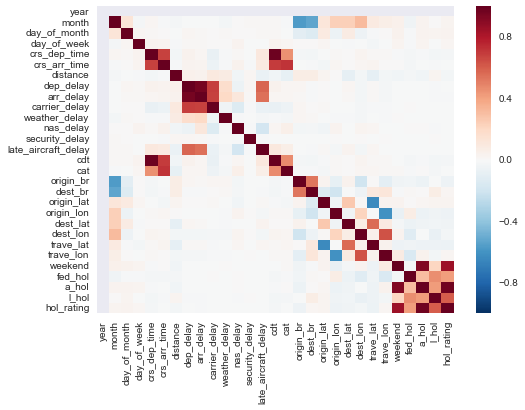

In [149]:
sns.heatmap(df_LAX.corr());

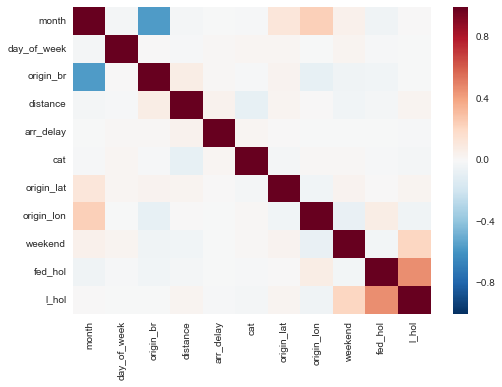

In [150]:
# interested in an arry of variables - check if there is strong correlation
cols =['month','day_of_week','unique_carrier','origin','origin_br','distance','arr_delay','cat','origin_lat','origin_lon','weekend','fed_hol','l_hol']
sns.heatmap(df_LAX[cols].corr());

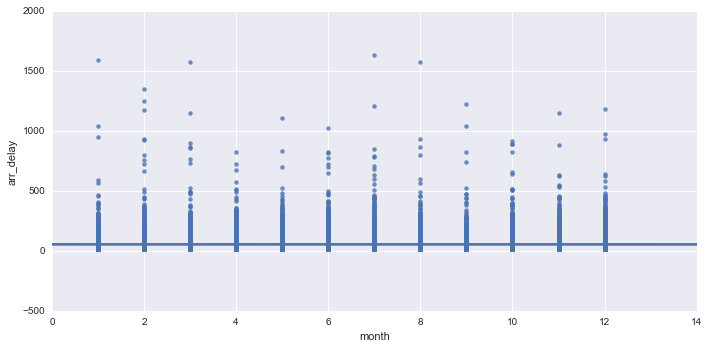

In [151]:
# keen to looking at relationship between potential IV and our desgianted DV -> arrival delay
sns.lmplot("month", "arr_delay", df_LAX, order=1, aspect=2);

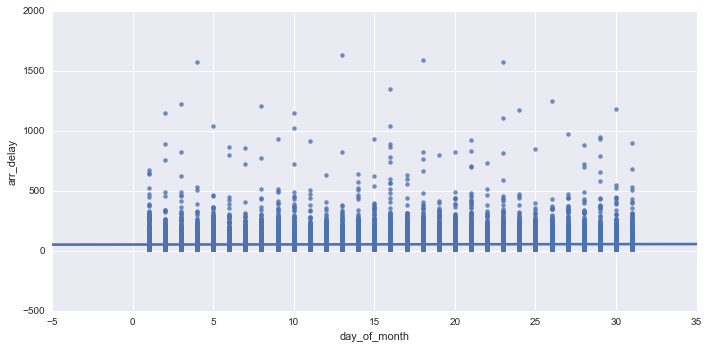

In [152]:
sns.lmplot("day_of_month", "arr_delay", df_LAX, order=1, aspect=2);

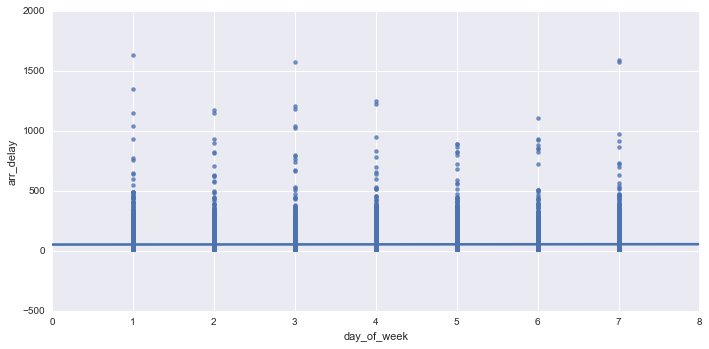

In [153]:
sns.lmplot("day_of_week", "arr_delay", df_LAX, order=1, aspect=2);

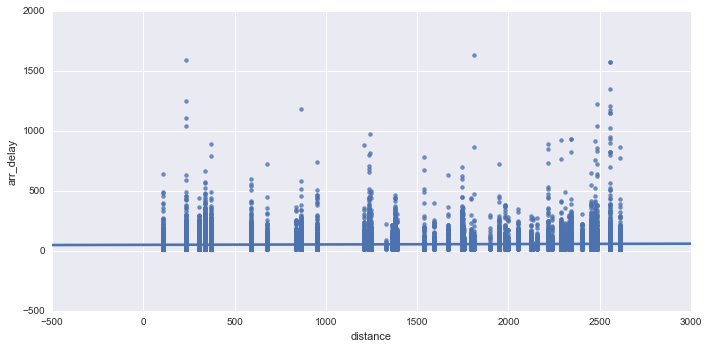

In [154]:
sns.lmplot("distance", "arr_delay", df_LAX, order=1, aspect=2);

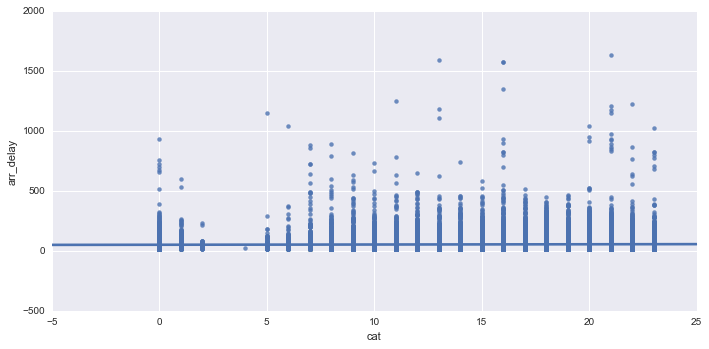

In [155]:
sns.lmplot("cat", "arr_delay", df_LAX, order=1, aspect=2);

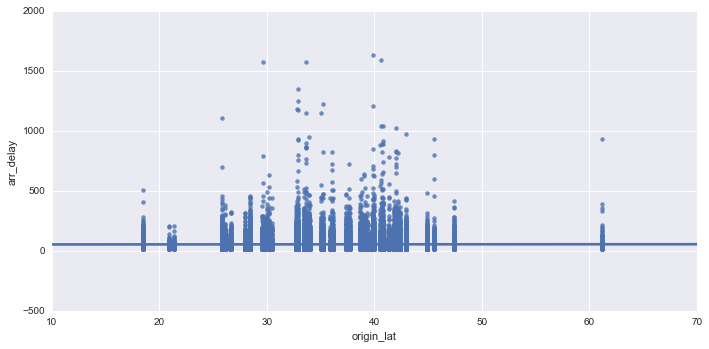

In [156]:
sns.lmplot("origin_lat", "arr_delay", df_LAX, order=1, aspect=2);

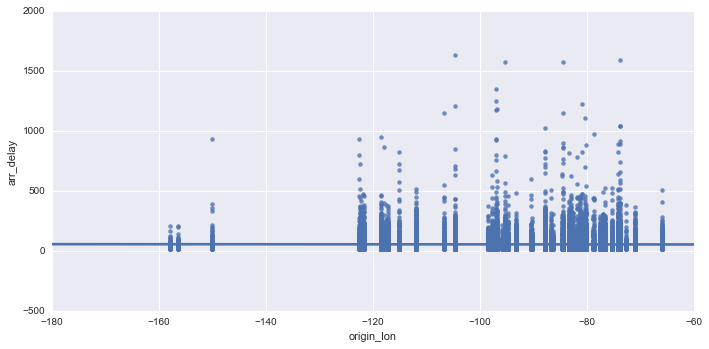

In [157]:
sns.lmplot("origin_lon", "arr_delay", df_LAX, order=1, aspect=2);

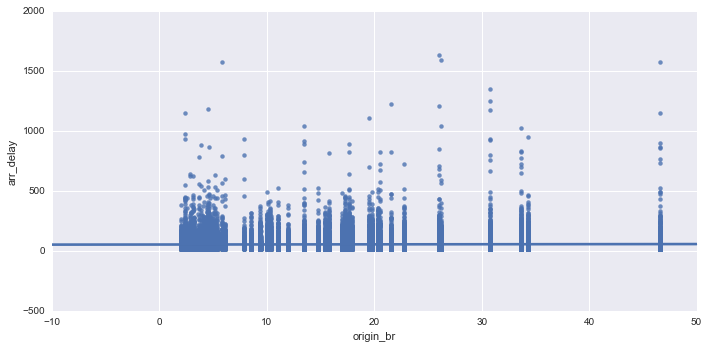

In [158]:
sns.lmplot("origin_br", "arr_delay", df_LAX, order=1, aspect=2);

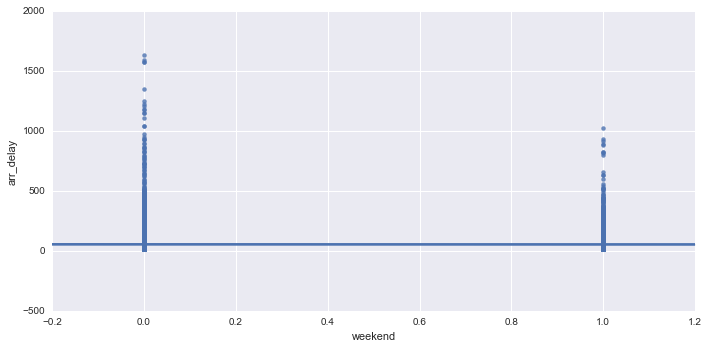

In [159]:
sns.lmplot("weekend", "arr_delay", df_LAX, order=1, aspect=2);

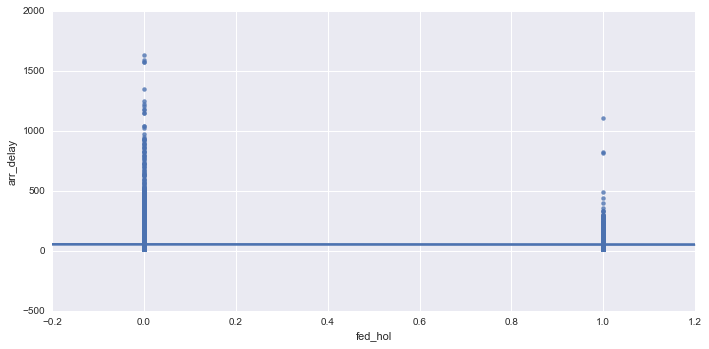

In [160]:
sns.lmplot("fed_hol", "arr_delay", df_LAX, order=1, aspect=2);

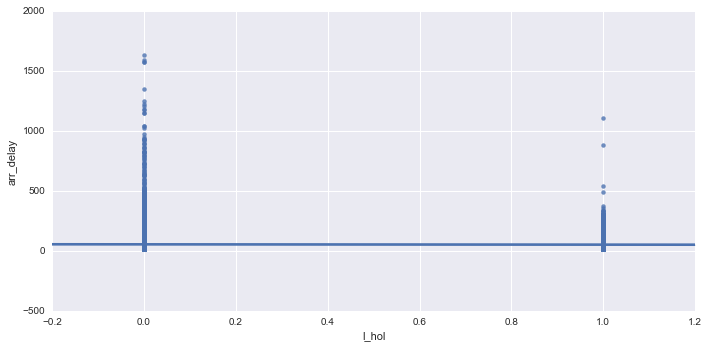

In [161]:
sns.lmplot("l_hol", "arr_delay", df_LAX, order=1, aspect=2);

In [162]:
df_LAX_new = df_LAX[cols]
df_LAX_new.head(10)

month  day_of_week unique_carrier origin  origin_br  distance  arr_delay  \
0       1            2             AA    JFK  26.244928    2475.0       25.0   
1       1            6             AA    JFK  26.244928    2475.0       79.0   
5       1            2             AA    JFK  26.244928    2475.0       52.0   
6       1            5             AA    JFK  26.244928    2475.0       18.0   
7       1            2             AA    JFK  26.244928    2475.0       23.0   
8       1            5             AA    JFK  26.244928    2475.0       23.0   
53      1            5             AA    JFK  26.244928    2475.0       49.0   
54      1            5             AA    JFK  26.244928    2475.0       20.0   
55      1            2             AA    JFK  26.244928    2475.0       20.0   
63      1            6             AA    OGG  26.244928    2486.0      131.0   

    cat  origin_lat  origin_lon  weekend  fed_hol  l_hol  
0    13   40.639751  -73.778925      0.0      0.0    0.0  
1    13   40.639751  -73.778925      0.0      0.0    0.0  
5    16   40.639751  -73.778925      0.0      0.0    0.0  
6    16   40.639751  -73.778925      0.0      0.0    0.0  
7    16   40.639751  -73.778925      0.0      0.0    0.0  
8    16   40.639751  -73.778925      0.0      0.0    0.0  
53   10   40.639751  -73.778925      0.0      0.0    0.0  
54   11   40.639751  -73.778925      0.0      0.0    0.0  
55   11   40.639751  -73.778925      0.0      0.0    0.0  
63    6   40.639751  -73.778925      0.0      0.0    0.0

In [163]:
df_LAX_new.to_csv('example.csv')

In [179]:
df_LAX_new = pd.read_csv('data/LAX.csv').drop('Unnamed: 0', 1)
df_LAX_new.head(10)

month  day_of_week unique_carrier origin  origin_br  distance  arr_delay  \
0      1            2             AA    JFK  26.244928      2475         25   
1      1            6             AA    JFK  26.244928      2475         79   
2      1            2             AA    JFK  26.244928      2475         52   
3      1            5             AA    JFK  26.244928      2475         18   
4      1            2             AA    JFK  26.244928      2475         23   
5      1            5             AA    JFK  26.244928      2475         23   
6      1            5             AA    JFK  26.244928      2475         49   
7      1            5             AA    JFK  26.244928      2475         20   
8      1            2             AA    JFK  26.244928      2475         20   
9      1            6             AA    OGG   3.019338      2486        131   

   cat  origin_lat  origin_lon  weekend  fed_hol  l_hol  
0   13   40.639751  -73.778925        0        0      0  
1   13   40.639751  -73.778925        0        0      0  
2   16   40.639751  -73.778925        0        0      0  
3   16   40.639751  -73.778925        0        0      0  
4   16   40.639751  -73.778925        0        0      0  
5   16   40.639751  -73.778925        0        0      0  
6   10   40.639751  -73.778925        0        0      0  
7   11   40.639751  -73.778925        0        0      0  
8   11   40.639751  -73.778925        0        0      0  
9    6   20.898650 -156.430458        0        0      0

In [180]:
df_LAX_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41102 entries, 0 to 41101
Data columns (total 13 columns):
month             41102 non-null int64
day_of_week       41102 non-null int64
unique_carrier    41102 non-null object
origin            41102 non-null object
origin_br         41102 non-null float64
distance          41102 non-null int64
arr_delay         41102 non-null int64
cat               41102 non-null int64
origin_lat        41102 non-null float64
origin_lon        41102 non-null float64
weekend           41102 non-null int64
fed_hol           41102 non-null int64
l_hol             41102 non-null int64
dtypes: float64(3), int64(8), object(2)
memory usage: 4.1+ MB


In [181]:
colsn = ['origin_br', 'distance', 'origin_lat', 'origin_lon']
df_LAX_n = df_LAX_new[colsn]
df_LAX_n = pd.concat([(df_LAX_n.select_dtypes(include=[int,float]) / df_LAX_n.select_dtypes(include=[int,float]).mean() )  / df_LAX_n.select_dtypes(include=[int,float]).std()], axis=1)

colsa = ['month','cat','day_of_week','unique_carrier','origin','weekend','fed_hol','l_hol']
df_LAX_a = df_LAX_new[colsa]

df_LAX_new1 = pd.concat([df_LAX_n, df_LAX_a], axis=1)
df_LAX_new1.head(10)

origin_br  distance  origin_lat  origin_lon  month  cat  day_of_week  \
0   0.150501  0.002428    0.203135    0.035685      1   13            2   
1   0.150501  0.002428    0.203135    0.035685      1   13            6   
2   0.150501  0.002428    0.203135    0.035685      1   16            2   
3   0.150501  0.002428    0.203135    0.035685      1   16            5   
4   0.150501  0.002428    0.203135    0.035685      1   16            2   
5   0.150501  0.002428    0.203135    0.035685      1   16            5   
6   0.150501  0.002428    0.203135    0.035685      1   10            5   
7   0.150501  0.002428    0.203135    0.035685      1   11            5   
8   0.150501  0.002428    0.203135    0.035685      1   11            2   
9   0.017314  0.002439    0.104460    0.075661      1    6            6   

  unique_carrier origin  weekend  fed_hol  l_hol  
0             AA    JFK        0        0      0  
1             AA    JFK        0        0      0  
2             AA    JFK        0        0      0  
3             AA    JFK        0        0      0  
4             AA    JFK        0        0      0  
5             AA    JFK        0        0      0  
6             AA    JFK        0        0      0  
7             AA    JFK        0        0      0  
8             AA    JFK        0        0      0  
9             AA    OGG        0        0      0

In [182]:
df_LAX_new1['month'] = df_LAX_new1['month'].astype(int).astype('str')
df_LAX_new1['cat'] = df_LAX_new1['cat'].astype(int).astype('str')
df_LAX_new1['day_of_week'] = df_LAX_new1['day_of_week'].astype(int).astype('str')

In [183]:
df_LAX_new1.head(10)

origin_br  distance  origin_lat  origin_lon month cat day_of_week  \
0   0.150501  0.002428    0.203135    0.035685     1  13           2   
1   0.150501  0.002428    0.203135    0.035685     1  13           6   
2   0.150501  0.002428    0.203135    0.035685     1  16           2   
3   0.150501  0.002428    0.203135    0.035685     1  16           5   
4   0.150501  0.002428    0.203135    0.035685     1  16           2   
5   0.150501  0.002428    0.203135    0.035685     1  16           5   
6   0.150501  0.002428    0.203135    0.035685     1  10           5   
7   0.150501  0.002428    0.203135    0.035685     1  11           5   
8   0.150501  0.002428    0.203135    0.035685     1  11           2   
9   0.017314  0.002439    0.104460    0.075661     1   6           6   

  unique_carrier origin  weekend  fed_hol  l_hol  
0             AA    JFK        0        0      0  
1             AA    JFK        0        0      0  
2             AA    JFK        0        0      0  
3             AA    JFK        0        0      0  
4             AA    JFK        0        0      0  
5             AA    JFK        0        0      0  
6             AA    JFK        0        0      0  
7             AA    JFK        0        0      0  
8             AA    JFK        0        0      0  
9             AA    OGG        0        0      0

In [184]:
df_LAX_month = pd.get_dummies(df_LAX_new1['month'])
df_LAX_new1 = pd.concat([df_LAX_new1, df_LAX_month], axis=1)
df_LAX_new1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41102 entries, 0 to 41101
Data columns (total 24 columns):
origin_br         41102 non-null float64
distance          41102 non-null float64
origin_lat        41102 non-null float64
origin_lon        41102 non-null float64
month             41102 non-null object
cat               41102 non-null object
day_of_week       41102 non-null object
unique_carrier    41102 non-null object
origin            41102 non-null object
weekend           41102 non-null int64
fed_hol           41102 non-null int64
l_hol             41102 non-null int64
1                 41102 non-null float64
10                41102 non-null float64
11                41102 non-null float64
12                41102 non-null float64
2                 41102 non-null float64
3                 41102 non-null float64
4                 41102 non-null float64
5                 41102 non-null float64
6                 41102 non-null float64
7                 41102 non-null float64


In [185]:
df_LAX_new1.rename(columns={'1': 'January', '2': 'February', '3': 'March', '4': 'April', '5': 'May', '6': 'June', '7': 'July', '8': 'August', '9': 'September', '10': 'October', '11': 'November', '12': 'December'}, inplace=True)
df_LAX_new1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41102 entries, 0 to 41101
Data columns (total 24 columns):
origin_br         41102 non-null float64
distance          41102 non-null float64
origin_lat        41102 non-null float64
origin_lon        41102 non-null float64
month             41102 non-null object
cat               41102 non-null object
day_of_week       41102 non-null object
unique_carrier    41102 non-null object
origin            41102 non-null object
weekend           41102 non-null int64
fed_hol           41102 non-null int64
l_hol             41102 non-null int64
January           41102 non-null float64
October           41102 non-null float64
November          41102 non-null float64
December          41102 non-null float64
February          41102 non-null float64
March             41102 non-null float64
April             41102 non-null float64
May               41102 non-null float64
June              41102 non-null float64
July              41102 non-null float64


In [173]:
df_LAX_WDay = pd.get_dummies(df_LAX_new1['day_of_week'])
df_LAX_new1 = pd.concat([df_LAX_new1, df_LAX_WDay], axis=1)
df_LAX_new1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41102 entries, 0 to 41101
Data columns (total 31 columns):
origin_br         41102 non-null float64
distance          41102 non-null float64
origin_lat        41102 non-null float64
origin_lon        41102 non-null float64
month             41102 non-null object
cat               41102 non-null object
day_of_week       41102 non-null object
unique_carrier    41102 non-null object
origin            41102 non-null object
weekend           41102 non-null int64
fed_hol           41102 non-null int64
l_hol             41102 non-null int64
January           41102 non-null float64
October           41102 non-null float64
November          41102 non-null float64
December          41102 non-null float64
February          41102 non-null float64
March             41102 non-null float64
April             41102 non-null float64
May               41102 non-null float64
June              41102 non-null float64
July              41102 non-null float64


In [186]:
df_LAX_new1.rename(columns={'1': 'Monday', '2': 'Tuesday', '3': 'Wednesday', '4': 'Thursday', '5': 'Friday', '6': 'Saturday', '7': 'Sunday'}, inplace=True)
df_LAX_new1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41102 entries, 0 to 41101
Data columns (total 24 columns):
origin_br         41102 non-null float64
distance          41102 non-null float64
origin_lat        41102 non-null float64
origin_lon        41102 non-null float64
month             41102 non-null object
cat               41102 non-null object
day_of_week       41102 non-null object
unique_carrier    41102 non-null object
origin            41102 non-null object
weekend           41102 non-null int64
fed_hol           41102 non-null int64
l_hol             41102 non-null int64
January           41102 non-null float64
October           41102 non-null float64
November          41102 non-null float64
December          41102 non-null float64
February          41102 non-null float64
March             41102 non-null float64
April             41102 non-null float64
May               41102 non-null float64
June              41102 non-null float64
July              41102 non-null float64


In [187]:
df_LAX_arrival = pd.get_dummies(df_LAX_new1['cat'])
df_LAX_new1 = pd.concat([df_LAX_new1, df_LAX_arrival], axis=1)
df_LAX_new1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41102 entries, 0 to 41101
Data columns (total 47 columns):
origin_br         41102 non-null float64
distance          41102 non-null float64
origin_lat        41102 non-null float64
origin_lon        41102 non-null float64
month             41102 non-null object
cat               41102 non-null object
day_of_week       41102 non-null object
unique_carrier    41102 non-null object
origin            41102 non-null object
weekend           41102 non-null int64
fed_hol           41102 non-null int64
l_hol             41102 non-null int64
January           41102 non-null float64
October           41102 non-null float64
November          41102 non-null float64
December          41102 non-null float64
February          41102 non-null float64
March             41102 non-null float64
April             41102 non-null float64
May               41102 non-null float64
June              41102 non-null float64
July              41102 non-null float64


In [188]:
df_LAX_new1.rename(columns={'0': '12am', '1': '1am', '2': '2am', '3': '3am', '4': '4am', '5': '5am', '6': '6am', '7': '7am', '8': '8am', '9': '9am', '10': '10am', '11': '11am', '12': '12pm', '13': '1pm', '14': '2pm', '15': '3pm', '16': '4pm', '17': '5pm', '18': '6pm', '19': '7pm', '20': '8pm', '21': '9pm', '22': '10pm', '23': '11pm'}, inplace=True)
df_LAX_new1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41102 entries, 0 to 41101
Data columns (total 47 columns):
origin_br         41102 non-null float64
distance          41102 non-null float64
origin_lat        41102 non-null float64
origin_lon        41102 non-null float64
month             41102 non-null object
cat               41102 non-null object
day_of_week       41102 non-null object
unique_carrier    41102 non-null object
origin            41102 non-null object
weekend           41102 non-null int64
fed_hol           41102 non-null int64
l_hol             41102 non-null int64
January           41102 non-null float64
October           41102 non-null float64
November          41102 non-null float64
December          41102 non-null float64
February          41102 non-null float64
March             41102 non-null float64
April             41102 non-null float64
May               41102 non-null float64
June              41102 non-null float64
July              41102 non-null float64


In [189]:
df_LAX_carrier = pd.get_dummies(df_LAX_new1['unique_carrier'])
df_LAX_new1 = pd.concat([df_LAX_new1, df_LAX_carrier], axis=1)
df_LAX_new1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41102 entries, 0 to 41101
Data columns (total 59 columns):
origin_br         41102 non-null float64
distance          41102 non-null float64
origin_lat        41102 non-null float64
origin_lon        41102 non-null float64
month             41102 non-null object
cat               41102 non-null object
day_of_week       41102 non-null object
unique_carrier    41102 non-null object
origin            41102 non-null object
weekend           41102 non-null int64
fed_hol           41102 non-null int64
l_hol             41102 non-null int64
January           41102 non-null float64
October           41102 non-null float64
November          41102 non-null float64
December          41102 non-null float64
February          41102 non-null float64
March             41102 non-null float64
April             41102 non-null float64
May               41102 non-null float64
June              41102 non-null float64
July              41102 non-null float64


In [190]:
df_LAX_regression = df_LAX_new1.drop(['month','cat',"day_of_week",'origin','weekend','unique_carrier'],axis=1)
df_LAX_regression.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41102 entries, 0 to 41101
Data columns (total 53 columns):
origin_br     41102 non-null float64
distance      41102 non-null float64
origin_lat    41102 non-null float64
origin_lon    41102 non-null float64
fed_hol       41102 non-null int64
l_hol         41102 non-null int64
January       41102 non-null float64
October       41102 non-null float64
November      41102 non-null float64
December      41102 non-null float64
February      41102 non-null float64
March         41102 non-null float64
April         41102 non-null float64
May           41102 non-null float64
June          41102 non-null float64
July          41102 non-null float64
August        41102 non-null float64
September     41102 non-null float64
12am          41102 non-null float64
1am           41102 non-null float64
10am          41102 non-null float64
11am          41102 non-null float64
12pm          41102 non-null float64
1pm           41102 non-null float64
2pm    

In [191]:
y = df_LAX_new['arr_delay']

from sklearn.linear_model import LinearRegression

est_delay = LinearRegression()

est_delay.fit(df_LAX_regression,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [192]:
from sklearn import feature_selection as fs

def f_regression_feature_selection(input, response):    
# use this against your feature matrix to determine p-values for
# each feature (we care about the second array it returns).
    return fs.univariate_selection.f_regression(input, response)    

# How many features don't meet the F test threshold?
sum(f_regression_feature_selection(df_LAX_regression,y)[0] < 10)
#[0] assume as F value

36

In [193]:
# Which column are we talking about?
select = f_regression_feature_selection(df_LAX_regression,y)[0] < 10
df_LAX_regression.columns[select]

Index([u'origin_br', u'origin_lon', u'fed_hol', u'l_hol', u'January',
       u'October', u'November', u'December', u'February', u'March', u'May',
       u'August', u'12am', u'1am', u'11am', u'1pm', u'2pm', u'3pm', u'4pm',
       u'5pm', u'6pm', u'7pm', u'2am', u'8pm', u'10pm', u'11pm', u'4am',
       u'5am', u'6am', u'8am', u'B6', u'DL', u'F9', u'HA', u'OO', u'VX'],
      dtype='object')

In [194]:
# difference between the ones available and the ones we wish to drop
post_select = df_LAX_regression.columns.difference(df_LAX_regression.columns[select])
# different --> drop

Xs = df_LAX_regression[post_select]
Xs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41102 entries, 0 to 41101
Data columns (total 17 columns):
10am          41102 non-null float64
12pm          41102 non-null float64
7am           41102 non-null float64
9am           41102 non-null float64
9pm           41102 non-null float64
AA            41102 non-null float64
AS            41102 non-null float64
April         41102 non-null float64
July          41102 non-null float64
June          41102 non-null float64
NK            41102 non-null float64
September     41102 non-null float64
UA            41102 non-null float64
US            41102 non-null float64
WN            41102 non-null float64
distance      41102 non-null float64
origin_lat    41102 non-null float64
dtypes: float64(17)
memory usage: 5.3 MB


In [195]:
# How many features don't meet the F test threshold?
sum(f_regression_feature_selection(Xs,y)[1] < 0.05)

17

In [196]:
# Sort the features based on their statistical significance 
ps = f_regression_feature_selection(Xs,y)[1]

p_score = zip(Xs.columns, ps)
ranked_p = sorted(p_score, key=lambda x:x[1])
# use a variable called x - start from first1 
ranked_p

[('WN', 6.3278780297055819e-29),
 ('origin_lat', 1.1369101904318751e-25),
 ('distance', 7.9416581394768024e-19),
 ('AA', 4.2938850572849273e-17),
 ('UA', 2.0729181035766293e-13),
 ('7am', 7.3517389446343289e-10),
 ('12pm', 1.1026141906033852e-08),
 ('July', 2.2597102974564683e-08),
 ('9am', 1.7926870645449428e-07),
 ('AS', 1.8358642582988116e-07),
 ('NK', 5.979530459197041e-07),
 ('9pm', 8.2778054854211484e-07),
 ('10am', 1.1796803062885045e-06),
 ('US', 1.1086032154555908e-05),
 ('April', 3.3440941597936732e-05),
 ('September', 6.4483891350640798e-05),
 ('June', 0.001006463405898339)]

In [197]:
from sklearn.linear_model import Ridge
# Let's first build univariate models to see how well each individual features performs
scores = []
for feat, score in ranked_p:
    est = Ridge()
    X = [[x] for x in Xs[feat]]
    est.fit(X,y)
    scores.append(est.score(X,y))

In [198]:
# Now let's build models which cummatively look well combinations of features performs
scores = []
feats = []
for feat, score in ranked_p:
    est = Ridge()
    feats.append(feat) # append each featue 1 by 1
    if len(feats) == 1:
        X = [[x] for x in Xs[feat]] # if only 1 x - needa tranform it as dataframe
    else:
        X = Xs[feats] # act Xs - putting into feature - and Xs as original dataset - feature here add 1 more at a time - and putit back to the selected dataset
    est.fit(X, y)
    scores.append(est.score(X,y))

In [199]:
# Now let's build models which cummatively look well combinations of features performs
from sklearn.cross_validation import cross_val_score

scores_cv = []
feats = []
for feat, score in ranked_p:
    est = Ridge()
    feats.append(feat)
    if len(feats) == 1:
        X = [[x] for x in Xs[feat]]
    else:
        X = Xs[feats]
    est.fit(X, y)
    scores_cv.append(cross_val_score(est,X,y).mean())

In [106]:
df_cv = pd.DataFrame(scores,index=feats, columns=['regular'])
df_cv.iplot()

In [200]:
df_cv = pd.DataFrame(scores,index=feats, columns=['regular'])
df_cv['cv'] = scores_cv # 1 more line

df_cv.iplot()

In [201]:
correlation = Xs[[x[0] for x in ranked_p]].corr()
correlation.apply(abs).iplot(kind='heatmap', colorscale='spectral')

In [202]:
from sklearn.feature_selection import RFE

# Create the RFE object and rank each features
est = Ridge()
rfe = RFE(estimator=est, n_features_to_select=1, step=1)

rfe.fit(Xs, y)
ranking = rfe.ranking_

scores = zip(Xs.columns, ranking) # only list them out not in ranking order
scores = sorted(scores, key=lambda x:x[1])
scores
#scores - name + ranking

[('origin_lat', 1),
 ('distance', 2),
 ('7am', 3),
 ('US', 4),
 ('9am', 5),
 ('WN', 6),
 ('10am', 7),
 ('12pm', 8),
 ('NK', 9),
 ('AA', 10),
 ('UA', 11),
 ('July', 12),
 ('September', 13),
 ('April', 14),
 ('AS', 15),
 ('9pm', 16),
 ('June', 17)]

In [203]:
pd.DataFrame(abs(len(ranking)-ranking), index=Xs.columns, columns=['feat']).sort_values('feat',ascending=False).iplot(kind='bar')

In [204]:
p_features = [x[0] for x in ranked_p][:5]
p_features

['WN', 'origin_lat', 'distance', 'AA', 'UA']

In [205]:
rfe_features = [x[0] for x in scores] [:5]
print 'P Value:', p_features
print 'RFE Value:', rfe_features

P Value: ['WN', 'origin_lat', 'distance', 'AA', 'UA']
RFE Value: ['origin_lat', 'distance', '7am', 'US', '9am']


In [206]:
for feats in [p_features, rfe_features]:
    est = Ridge()
    X = Xs[feats]
    print cross_val_score(est, X, y).mean()

0.00349744528503
0.00201265037053


In [207]:
import statsmodels.api as sm

In [208]:
model = sm.OLS(y, Xs)
results = model.fit()
print results.summary()

                            OLS Regression Results                            
Dep. Variable:              arr_delay   R-squared:                       0.425
Model:                            OLS   Adj. R-squared:                  0.425
Method:                 Least Squares   F-statistic:                     1789.
Date:                Sun, 25 Sep 2016   Prob (F-statistic):               0.00
Time:                        02:04:49   Log-Likelihood:            -2.2860e+05
No. Observations:               41102   AIC:                         4.572e+05
Df Residuals:                   41085   BIC:                         4.574e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
10am          -6.9375      1.591     -4.362      0.0